# **ABOUT THE DATASET**
In total, we have *27,560* images

The dataset is a folder named "cell_images"

"cell_images" contains 2 subfolders "train" and "test"

"train" and "test" each hold images of parasitized and uninfected cells

# **How To Get The Data**
Step 1: Download zipped file (337MB) from: https://drive.google.com/file/d/1N1gcN8_5dZVlIejoC00QZLSZFhGoSoQb/view

Step 2: Extract "cell_images" folder

Step 3: Upload "cell_images" to your google drive to run on Google Colab. Another option is working in a local installation of Jupyter Notebook without uploading anything.

Data citation: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_dir = "/content/drive/MyDrive/Tutorials Drive/Malaria Classification/cell_images"

In [4]:
os.listdir(data_dir)

['malaria_detector.h5', 'train', 'test']

In [5]:
from matplotlib.image import imread

In [6]:
test_path = data_dir + "/test/"
train_path = data_dir + "/train/"

In [7]:
os.listdir(test_path)

['uninfected', 'parasitized']

In [8]:
#just the file name
para_ex = os.listdir(train_path + "parasitized")[12000]

In [9]:
#the full file path
para_cell = imread(train_path + "parasitized/" + para_ex)

(154, 145, 3)

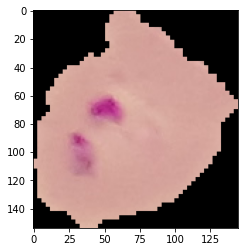

In [10]:
plt.imshow(para_cell)
para_cell.shape

In [11]:
#just the file name
uninfected_ex = os.listdir(train_path + "uninfected")[7000]

In [12]:
uninfected_cell = imread(train_path + "uninfected/" + uninfected_ex)

(127, 133, 3)

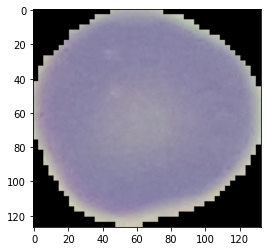

In [13]:
plt.imshow(uninfected_cell)
uninfected_cell.shape

In [14]:
image_shape = (130,130,3)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode="constant")

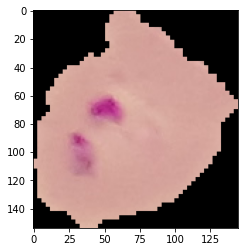

In [17]:
plt.imshow(para_cell)

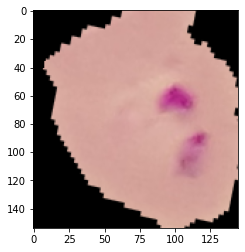

In [18]:
plt.imshow(image_gen.random_transform(para_cell))

In [19]:
#flow from directory is used to load transformed images into AI for training
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

In [21]:
#design model architecture
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape = image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=2)
batch_size = 16

In [24]:
#generate train images
train_image_gen = image_gen.flow_from_directory(train_path, 
                                               target_size=(130,130),
                                               color_mode = 'rgb',
                                               class_mode='binary',
                                               shuffle=True)

Found 24958 images belonging to 2 classes.


In [25]:
test_image_gen = image_gen.flow_from_directory(test_path, 
                                               target_size=(130,130),
                                               color_mode = 'rgb',
                                               class_mode='binary',
                                               shuffle=False)
##play around with shuffle=True or False

Found 2600 images belonging to 2 classes.


In [26]:
#integer representation of labels
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [27]:
"""results= model.fit_generator(train_image_gen, 
                             epochs = 20,
                             validation_data=test_image_gen,
                             callbacks=[early_stop])"""

'results= model.fit_generator(train_image_gen, \n                             epochs = 20,\n                             validation_data=test_image_gen,\n                             callbacks=[early_stop])'

In [28]:
#training takes a while, we will load a pretrained model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Tutorials Drive/Malaria Classification/cell_images/malaria_detector.h5')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [30]:
#run model on test images
#outputs loss and accuracy in the form [loss, accuracy]
#takes while to compute
#we have 87% accuracy
#model.evaluate_generator(test_image_gen)

In [31]:
#get the path for a single file of your choice from the test path
parasitic = test_path + "parasitized/" + os.listdir(test_path + "parasitized")[50]
parasitic

'/content/drive/MyDrive/Tutorials Drive/Malaria Classification/cell_images/test/parasitized/C130P91ThinF_IMG_20151004_142109_cell_144.png'

In [32]:
from tensorflow.keras.preprocessing import image

In [33]:
#load in the image from the path
my_image = image.load_img(parasitic, target_size = (130,130,3))
type(my_image)

PIL.Image.Image

In [34]:
#convert the image to numpy.ndarray
my_image_arr = image.img_to_array(my_image)
type(my_image_arr)

numpy.ndarray

In [35]:
my_image_arr.shape

(130, 130, 3)

In [36]:
#manually add a new "batch" dimension
my_image_arr = np.expand_dims(my_image_arr, axis=0)
my_image_arr.shape

(1, 130, 130, 3)

In [37]:
#run AI on the image
model.predict(my_image_arr)

array([[0.]], dtype=float32)

In [38]:
#prediction is the class "0" from above output

In [39]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [40]:
#class 0 corresponds to parasitized